# Czytanie danych zawierających ciągi znaków NaN

NaN to oznaczenie ,,Not a Number'' które może pojawić się (na wydrukach z programu komputerowego) gdy procesor wykona jakąś operację ,,niedozwoloną''.

Dzielenie przez zero wykonywane jest przez współczesne bez problemów, generując jako wynik wartość ,,nieskończoność'' (która podczas wyprowdzania oznaczona będzie `Inf` albo `-Inf`). Procesor poprawnie wykonuje proste operacje na nieskończonościach, na przykłąd `Inf + 1` to będzie `Inf`. Natomiast próba dodawania $-\infty + \infty$ wygeneruje wynik `NaN`.
### Dygresja: przykład NaNów i nieskończoności

In [1]:
duze = 1e300
male = 1e-300
dzielenie = duze/male

In [2]:
dzielenie

inf

In [3]:
dzielenie +5

inf

In [4]:
dzielenie - dzielenie

nan

### Koniec dygresji
Dane generowane przez RRDB będą zawierały takie znaczniki wszędzie tam, gdzie z jakichś powodów, nie udało się dokonać pomiarów. Na przykład plik AVERAGE86400.dat zawiera takie wartości 

In [5]:
import numpy as np
import numpy.ma as ma

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,9) # Tu definiujemy rozmiary wykresu. 
# Standardowo wydaje się być zbyt mały.

Funkcja [`genfromtext()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) pozwala takie dane importować (ale zachowując wartości `nan` w wybranych punktach. Sprawdźmy co się dzieje w 19 wierszu pliku `AVERAGE86400.dat`?

In [7]:
np.genfromtxt('AVERAGE86400.dat')[19,:]

array([1.4557536e+09,           nan])

In [8]:
np.isnan(np.genfromtxt('AVERAGE86400.dat')[19,1])

True

In [9]:
np.isnan(np.genfromtxt('AVERAGE86400.dat')[19,0])

False

Funkcja [`np.isnan()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.isnan.html) pozwala sprawdzić czy zmienna przyjmuje wartośc NaN.

Zatem, wydaje się, że można tu użyć metody maskowania tablic opisanej [gdzie indziej]() używając funkcji [`masked_invalid`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ma.masked_invalid.html#numpy.ma.masked_invalid) lub [`masked_where`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ma.masked_where.html#numpy.ma.masked_where).
### Odrzucenie NaNów

In [10]:
dane = np.genfromtxt('AVERAGE1800.dat')

In [11]:
temperatura = ma.masked_invalid(dane)

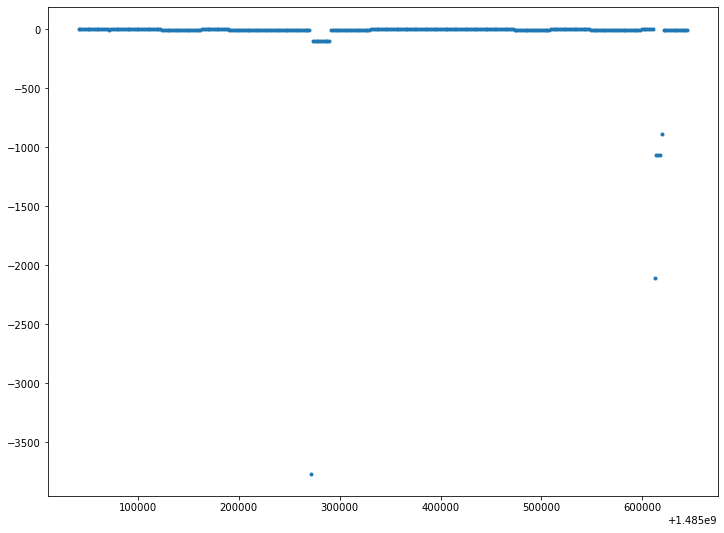

In [12]:
plt.plot(dane[:,0],dane[:,1],'.');
plt.show()

### Odrzucenie wartości błędnych
Okazuje się, że dane ciągle są nieprawdopodobne (zawierają błędne wartości). Zatem trzeba je filtrować ze względu na te wartości i NaN-y. Przyjmijmy, że temperatury większe od $55^o$ i mniejsze od $-25^o$ są nieprawdopodobne.

Można to zapewne zrobić na wiele sposobów: albo stworzyć dwie maski i połączyć je operatorem OR, albo spróbować od razu stworzyć maskę na podstawie złożonego warunku. Skorzystamy z funkcji `np.logical_or`, która pozwala wykonywać operacje logiczne na elemantach całych tablic.

In [13]:
temp = dane[:,1]
temp = ma.masked_where(np.logical_or(np.isnan(temp), np.logical_or(temp < -25, temp > 55)), temp)
czas = ma.masked_array(dane[:,0], mask=temp.mask)

In [14]:
temp[~temp.mask].data

array([-0.9689304 , -0.9689304 , -0.9689304 , -0.9689304 , -0.9689304 ,
       -0.9689304 , -0.9689304 , -0.9689304 , -0.9689304 , -0.9689304 ,
       -0.9689304 , -0.9689304 , -0.9689304 , -0.9689304 , -0.9689304 ,
       -0.9689304 , -0.97132976, -0.99075683, -0.83426618, -0.59789995,
       -0.30984787,  0.06529007,  0.55961978,  1.01605712,  1.49648211,
        2.02862636,  2.38894571,  2.54215373,  2.94817462,  3.58848959,
        4.11365971,  4.39019901,  3.46231264,  1.9996722 ,  1.3706712 ,
        1.02434473,  0.77193505,  0.76138098,  0.57264191,  0.32903536,
        0.01951746, -0.27134013, -0.39613435, -0.50011568, -0.67656486,
       -0.8681121 , -1.08714175, -1.18525492, -1.28565313, -1.24108625,
       -1.04606541, -1.08572976, -1.33585592, -1.60743693, -1.85790117,
       -2.08819171, -2.28403202, -2.53051551, -2.75360595, -2.85811913,
       -2.88870606, -2.99370083, -3.19580117, -3.15671801, -2.74186134,
       -2.28816073, -1.69171359, -1.02051107, -0.10649571,  0.55

In [15]:
czas = czas[~czas.mask].data
temp = temp[~temp.mask].data

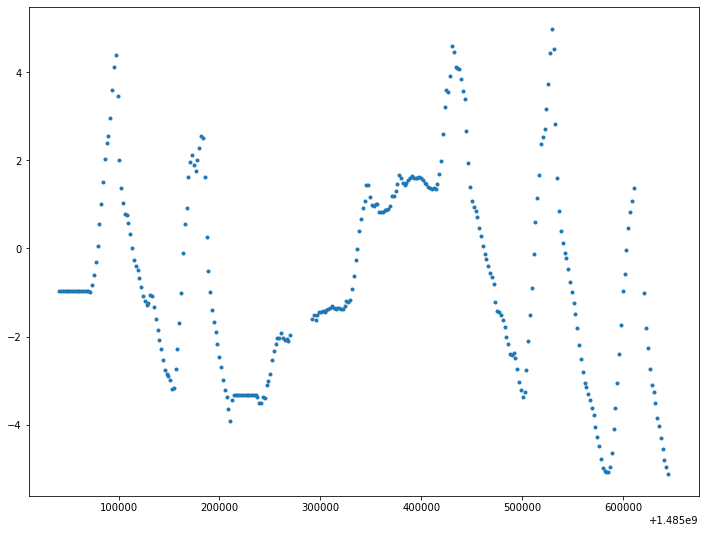

In [16]:
plt.plot(czas, temp, '.')
plt.show()

Teraz powinniśmy jeszcze zastąpić czymś odrzucone wartości. Można, w tym celu, posłużyć sę interpolacją jak to opisano w innym notatniku. Nie trzeba — choć można — robić resamplingu, wystarczy użyć interpolacji aby zastąpić „puste miejsca” na wykresie danymi z interpolacji.

### Opis osi X

Unix timestamp może jest i wygodny, ale trudno zorientować się jakiego okresu czasu dotyczy powyższy wykres. Chcielibyśmy mieś os X opisaną jako daty.

W tym celu należy (niestety) skonwertować timestamp do postaci zrozumiałej dla oprogramowania. Służy do tego funkcja [`fromtimestamp`](https://docs.python.org/3/library/datetime.html#datetime-objects)

In [17]:
import matplotlib.dates as md
import datetime as dt

In [18]:
dates=[dt.datetime.fromtimestamp(ts) for ts in czas]

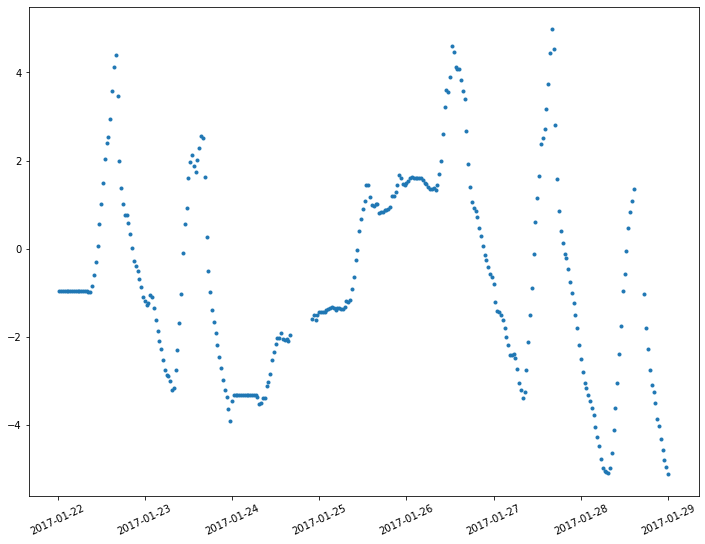

In [19]:
plt.xticks( rotation=25 )
ax = plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, temp, '.')
plt.show()

Czasami będziemy potrzebowali aby zastąpić czymś wartości w odrzuconych punktach. Można wówczas posłużyć się interpolacją w sposób opisany [gdzie indziej]().